In [472]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

In [473]:
#Read main data to DataFrame
cleaned_df = pd.read_csv('processed_data/cleaned_df.csv', index_col=0)  

In [474]:
df_original = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

df_out=df_original[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]

In [475]:
cleaned_df.drop(cleaned_df[df_out.iloc[cleaned_df.index].z_all_06.isna()].index, axis=0, inplace=True)

In [476]:
cleaned_df["z_all_06"]=df_out.iloc[cleaned_df.index].z_all_06

In [477]:
cp_cols=["hogarid_old"]

In [478]:
cleaned_df.drop(cp_cols, axis=1, inplace=True)

In [479]:
def outlier_removal(df, cols):
    outlier_threshold = []
    for col in cols:
            q3 = np.nanpercentile(df[col], 75)
            q1 = np.nanpercentile(df[col], 25)
            iqr = q3 - q1
            out_low = q1 - 3*iqr
            out_high = q3 + 3*iqr
            outlier_threshold.append([out_low, out_high])
    outliers_indexs=[]
    for col,k in zip(cols,range(len(cols))):
        #outliers_indexs_in_col=[]
        for i in df[col].index:
            if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
                outliers_indexs.append(i)
        #outliers_indexs.append(outliers_indexs_in_col)
    return df.drop(list(set(outliers_indexs)), axis=0)

cleaned_df=outlier_removal(cleaned_df, ["z_all_06"])

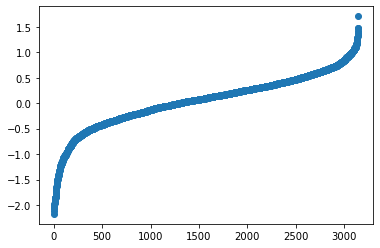

In [480]:
plt.scatter([i for i in range(len(cleaned_df["z_all_06"].sort_values().values))], cleaned_df["z_all_06"].sort_values().values)

(array([ 22.,  29.,  72., 166., 517., 921., 907., 409.,  96.,   6.]),
 array([-2.1753304 , -1.7871083 , -1.3988862 , -1.0106641 , -0.62244195,
        -0.23421985,  0.15400226,  0.54222435,  0.9304465 ,  1.3186686 ,
         1.7068907 ], dtype=float32),
 <BarContainer object of 10 artists>)

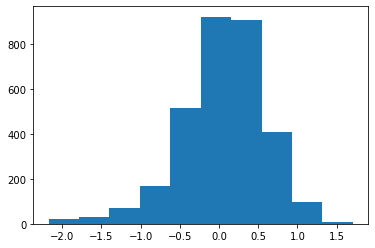

In [481]:
plt.hist(cleaned_df["z_all_06"])

In [482]:
cleaned_df["zall06_cat"] = pd.cut(cleaned_df["z_all_06"],
                               bins=[-np.inf, -0.75, -0.25, 0.25, 0.75, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [483]:
cleaned_df["zall06_cat"].value_counts().sort_values()

1     204
5     212
2     574
4     962
3    1193
Name: zall06_cat, dtype: int64

### ITE

-Regressio
-Random forest
-XGBoost

In [484]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = list(cleaned_df.columns)
covariates.remove(treatment)
covariates.remove(outcome)
covariates.remove("zall06_cat")

In [485]:
cleaned_df.z_all_06.values

array([ 0.45015588,  0.01125175, -0.5053326 , ...,  0.43954134,
        0.03532236, -0.03708899], dtype=float32)

In [486]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, stratify=cleaned_df.zall06_cat, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
y_train = train[outcome]
X_train = train[covariates+["tr"]]

X_test = test[covariates+["tr"]]
y_test =  test[outcome]

In [487]:
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [488]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train,y_train)

 
    # lets comare all of them 
models = [(lin_reg,"lin_reg"),
          (forest_reg,'Random Forest'),
          (xg_reg,"XGboost")]
for model in models:
    scores = cross_val_score(model[0], X_test, y_test, scoring='r2', cv=10)
    display_scores(scores, model[1])
    scores = cross_val_score(model[0], X_test, y_test, scoring='neg_root_mean_squared_error', cv=10)
    display_scores(-scores, model[1])

---- lin_reg ----
Mean: 0.16572176939407063
Standard deviation: 0.13669529756934296
---- lin_reg ----
Mean: 0.4649660490697759
Standard deviation: 0.05655469561341081
---- Random Forest ----
Mean: 0.256868404894435
Standard deviation: 0.11754495510759008
---- Random Forest ----
Mean: 0.43900965135629316
Standard deviation: 0.05229714218643298
---- XGboost ----
Mean: 0.1145956817590629
Standard deviation: 0.20694859167805874
---- XGboost ----
Mean: 0.47583613991737367
Standard deviation: 0.05655721210992836


In [529]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(clf, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=3,
        scoring="neg_root_mean_squared_error",
        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    )

    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)

    plt.subplots(figsize=(5,4))
    plt.plot(train_sizes, train_mean, label="train")
    plt.plot(train_sizes, test_mean, label="validation")
    plt.ylim(0,0.55)

    plt.title("Learning Curve"+title)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend(loc="best")

    plt.show()

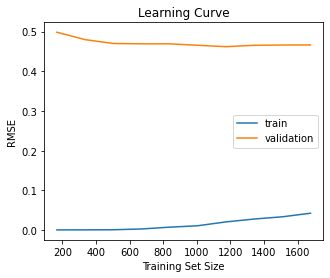

In [490]:
clf=xgb.XGBRegressor()
plot_learning_curve(clf,X_train, y_train, " base XGB")

### HYPERPARAMETER TUNING RF

In [491]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500]}


In [492]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=-1,
                               random_state=42, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=1000,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 144, 188, 233,
                                                         277, 322, 366, 411,
                                                         455, 500]},
                   random_state=42, verbose=-1)

In [493]:
rf_random.best_params_

{'n_estimators': 144,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [494]:
base_model = RandomForestRegressor( random_state = 42)
scores = cross_val_score(base_model, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Base RF (r2)")
scores = cross_val_score(base_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Base RF (rmse)")


best_random = rf_random.best_estimator_
scores = cross_val_score(best_random, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Best random RF (r2)")
scores = cross_val_score(best_random, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Best random RF (rmse)")

---- Base RF (r2) ----
Mean: 0.317631617474437
Standard deviation: 0.04255727768278685
---- Base RF (rmse) ----
Mean: 0.4349636485288519
Standard deviation: 0.03656607420901681
---- Best random RF (r2) ----
Mean: 0.3268539347231068
Standard deviation: 0.044675232373315096
---- Best random RF (rmse) ----
Mean: 0.4327099718572162
Standard deviation: 0.04028460387341648


### HYPERPARAMETER TUNNING XGB

In [496]:
import scipy as sp

param_dist = {'boosting_type': ['gbdt', 'dart'],
                    'num_leaves': sp.stats.randint(2, 500),
                    'subsample_for_bin': sp.stats.randint(10, 1001),
                    'min_split_gain': sp.stats.uniform(0, 0.5),
                    'min_child_weight': sp.stats.uniform(1e-6, 1e-2),
                    'reg_alpha': sp.stats.uniform(0, 1e-2),
                    'reg_lambda': sp.stats.uniform(0, 1e-2),
                    'application': ['regression_l2'],
                    'subsample_freq': sp.stats.randint(1, 11),
                    'subsample': sp.stats.uniform(1e-3, 0.99),
                    'colsample_bytree': sp.stats.uniform(1e-3, 0.5),
                    'learning_rate': sp.stats.uniform(1e-6, 0.3),
                    'max_depth': sp.stats.randint(-1, 200),
                    'n_estimators': sp.stats.randint(100, 1000),
                    'extra_trees':[True]
                 }

In [497]:
lgbm = lgb.LGBMRegressor(objective='regression', n_jobs=1)
rscv = RandomizedSearchCV(
                              estimator=lgbm,
                              param_distributions=param_dist,
                              cv=3,
                              n_iter=10000,
                              n_jobs=4,
                              verbose=1,
                              refit=True,
                            )
rscv = rscv.fit(X_train, y_train)

Fitting 3 folds for each of 10000 candidates, totalling 30000 fits


In [498]:
rscv.best_params_

{'application': 'regression_l2',
 'boosting_type': 'gbdt',
 'colsample_bytree': 0.38336326335596094,
 'extra_trees': True,
 'learning_rate': 0.17903385673674205,
 'max_depth': 158,
 'min_child_weight': 0.008879161272281614,
 'min_split_gain': 0.1593340443302288,
 'n_estimators': 473,
 'num_leaves': 459,
 'reg_alpha': 0.005018962703400557,
 'reg_lambda': 0.002397730115616338,
 'subsample': 0.9806477292744467,
 'subsample_for_bin': 557,
 'subsample_freq': 9}

In [499]:
base_lightgbm =lgb.LGBMRegressor()
scores = cross_val_score(base_lightgbm, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Base LightGBM (r2)")
scores = cross_val_score(base_lightgbm, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Base LightGBM (rmse)")

best_lightgbm= rscv.best_estimator_
scores = cross_val_score(best_ligthGBM, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Best random grid lightGBM (r2)")
scores = cross_val_score(best_ligthGBM, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Best random grid lightGBM (rmse)")

---- Base LightGBM (r2) ----
Mean: 0.3251620810209908
Standard deviation: 0.05792372012144613
---- Base LightGBM (rmse) ----
Mean: 0.4326438764796996
Standard deviation: 0.04108315678000423
---- Best random grid lightGBM (r2) ----
Mean: 0.3228661709141791
Standard deviation: 0.04466303850003907
---- Best random grid lightGBM (rmse) ----
Mean: 0.4336112277294483
Standard deviation: 0.04077849093670464


In [ ]:
COMPARACIÓ MODELS

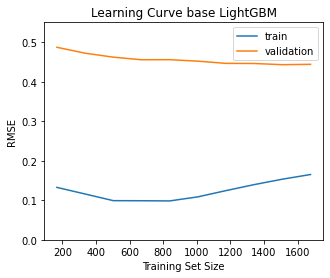

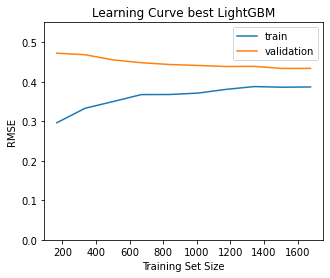

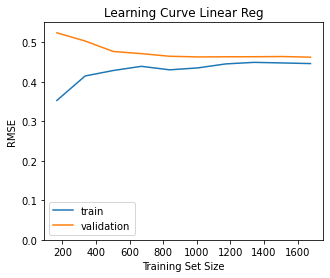

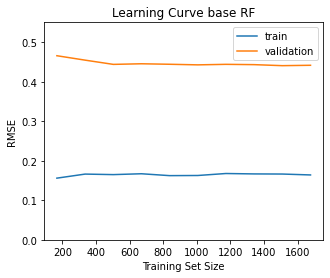

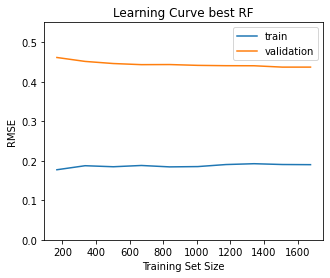

In [530]:
plot_learning_curve(base_lightgbm, X_train, y_train, " base LightGBM")
plot_learning_curve(best_lightgbm, X_train, y_train, " best LightGBM")
plot_learning_curve(lin_reg, X_train, y_train, " Linear Reg")
plot_learning_curve(base_model, X_train, y_train, " base RF")
plot_learning_curve(best_random, X_train, y_train, " best RF")


In [595]:
def predict_subplot(clf, fila, col, train, tit):
    clf.fit(X_train, y_train)
    
    if train=="train":
        y_pred=clf.predict(X_train)
    else:
        y_pred=clf.predict(X_test)
        
    predicted=pd.DataFrame(y_pred, columns=["y_pred"])
    if train=="train":
        predicted["y_true"]=y_train.values
    else:
        predicted["y_true"]=y_test.values
        
    predicted.sort_values(by="y_true", inplace=True)
    
    X=[i for i in range(len(y_pred))]
    y=predicted.y_pred
    
    #spline que interpola el nuvol X,y (y_pred)
    pts = np.vstack((X, y)) 
    (tck, u), fp, ier, msg = splprep(pts, u=None, per=0, k=3, full_output=True) 
    new_points = splev(u, tck)
    
    axs[fila,col].scatter(X, y, s=1)
    axs[fila,col].plot(new_points[0], new_points[1], 'b')
    axs[fila,col].scatter(X, predicted.y_true.values, s=1)
    axs[fila,col].set_title(tit)
    axs[fila,col].set_xlabel(None)
 

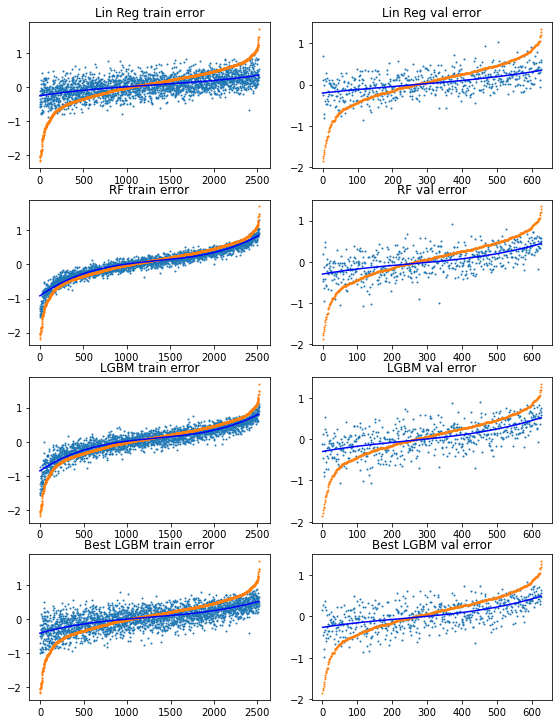

In [602]:
fig, axs = plt.subplots(4, 2,figsize=(8,10))
fig.tight_layout()

predict_subplot(lin_reg, 0, 0, "train", "Lin Reg train error")
predict_subplot(lin_reg, 0, 1, "test", "Lin Reg val error")

predict_subplot(base_model, 1, 0, "train", "RF train error")
predict_subplot(base_model, 1, 1, "test", "RF val error")

predict_subplot(base_lightgbm, 2, 0,"train", "LGBM train error")
predict_subplot(base_lightgbm, 2, 1,"test", "LGBM val error")

predict_subplot(best_lightgbm, 3, 0, "train", "Best LGBM train error")
predict_subplot(best_lightgbm, 3, 1, "test", "Best LGBM val error")

### CALCULEM ITE

Creem el dataset corresponent als contrafactuals de les nostes dades.

In [603]:
counterfactual_df=cleaned_df.drop("z_all_06",axis=1)
a=counterfactual_df["tr"]+1
counterfactual_df["tr"]=a%2

Entrenem el model que hem escollit amb totes les nostres dades i predim el contrafactual.

In [ ]:
best_lightgbm=light


In [1]:
best_lightgbm.train(clean)
counterfactual=best_lightgbm.predict(counterfactual_df)

NameError: name 'best_lightgbm' is not defined

In [ ]:
observed=cleaned_df["z_all_06"]
counterfactuals=pd.Series(counterfactual, index=observed.index)

In [ ]:
observed

In [ ]:
ite_temp=pd.Series([observed[i]-counterfactuals[i] for i in observed.index if cleaned_df.tr[i]==1], index=cleaned_df[cleaned_df.tr==1].index)
ite_temp1=pd.Series([counterfactuals[i]-observed[i] for i in observed.index if cleaned_df.tr[i]==0], index=cleaned_df[cleaned_df.tr==0].index)
ite=pd.concat([ite_temp,ite_temp1])
ite.sort_index(inplace=True)

In [ ]:
ite.describe()

In [ ]:
import seaborn as sb

sb.histplot(ite)

In [ ]:
cleaned_df.z_all_06.describe()

NO CONSIDERAR: ite amb counterfactual i observed predits pel model

In [ ]:
observed_df=cleaned_df.drop("z_all_06",axis=1)
observed_predict=forest_reg.predict(observed_df)
observed_predict=pd.Series(observed_predict, index=observed_df.index)

In [ ]:
ite1=[observed_predict[i]-counterfactuals[i] for i in observed_predict.index if cleaned_df.tr[i]==1]+[counterfactuals[i]-observed_predict[i] for i in observed_predict.index if cleaned_df.tr[i]==0 ]

In [ ]:
ite1=pd.Series(ite1, index=cleaned_df.index)
ite1.describe()

In [ ]:
sb.histplot(ite1)

In [ ]:
ite1.value_counts()

### ESTRATIFICACIO ITE

Quartils i std.

1. Separem <=q25, q25<...<=q50, q50<=q75, q75<
2. STD

In [ ]:
quartils=ite.quantile([0.25,0.5, 0.75])

In [ ]:
ite0=ite[ite<=quartils.iloc[0]]

In [ ]:
ite1=ite[ite<=quartils.iloc[1]]
ite1.drop(ite0.index, inplace=True)

In [ ]:
ite2=ite[ite<=quartils.iloc[2]]
ite2.drop(ite0.index, inplace=True)
ite2.drop(ite1.index, inplace=True)

In [ ]:
ite3=ite.copy()
ite3.drop(ite0.index, inplace=True)
ite3.drop(ite1.index, inplace=True)
ite3.drop(ite2.index, inplace=True)

In [ ]:
ite0_df=cleaned_df.loc[ite0.index]
ite1_df=cleaned_df.loc[ite1.index]
ite2_df=cleaned_df.loc[ite2.index]
ite3_df=cleaned_df.loc[ite3.index]

In [ ]:
shap=[[stats.shapiro(ite0_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite1_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite2_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite3_df[col].values).pvalue for col in normal_cols]]

shap_df=pd.DataFrame(shap,columns=normal_cols)

In [ ]:
#fem el test de shapiro a els subgrups (generats al estratificar la ite en quartils) de les variables normals. 
#Surt normalitat arreu, aixi que si tenen desv std entre ells normals, podrem aplicar t-tests per comprovar 
#si les mitjanes son iguals
shap_df

In [ ]:
std=[[np.std(ite0_df[col].values) for col in normal_cols],
        [np.std(ite1_df[col].values) for col in normal_cols],
        [np.std(ite2_df[col].values) for col in normal_cols],
        [np.std(ite3_df[col].values) for col in normal_cols]]
std_df=pd.DataFrame(std,columns=normal_cols)

In [ ]:
std_df

In [ ]:
ite0_df[normal_cols].describe()

In [ ]:
ite3_df[normal_cols].describe()

In [ ]:
import scipy
from scipy import stats
    
ttestp_df=[[stats.ttest_ind(ite1_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite2_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite2_df[col].values, ite1_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite1_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite2_df[col].values).pvalue for col in normal_cols]
         ]
ttest_df=pd.DataFrame(ttestp_df,columns=normal_cols, index=["0-1","0-2","0-3","1-2","1-3","2-3"])

In [ ]:
#si p<0.05 podem assumir que les mitjanes son diferents (descartem la hipotesi nulla)
ttest_df.style.background_gradient(cmap="Blues")